In [1]:
!pip install transformers datasets accelerate
!pip install librosa

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached accelerate-1.2.1-py3-none-any.whl.metadata (19 kB)
  Using cached regex-2024.11.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached aiohttp-3.11.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.7 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.5.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached multi

In [105]:
from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoModelForAudioClassification
from datasets import load_dataset, Dataset
import torch
import sklearn
import json, os, time, glob

import numpy as np
import librosa
from collections import defaultdict
from pprint import pprint

from transformers import Trainer

import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
path = 'Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/meta.json'
arrays = np.load('/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz')
meta = json.load(open('/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/meta.json', 'r'))

In [107]:
print(arrays)
print('\n')

print(arrays['X'])
print('\n')

print(arrays['y'])
print('\n')

print(arrays['groups'])

NpzFile '/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz' with keys: X, y, groups


[[ 3.2830704e-04  9.9163875e-03  1.6845936e-02 ...  4.8440071e-03
   6.7358743e-04 -3.9298702e-03]
 [-8.2107643e-03 -9.7427005e-03 -5.7625356e-03 ...  5.6111747e-03
   7.0165722e-03  3.7530088e-03]
 [-6.0349256e-03 -1.7513758e-02 -2.4519343e-02 ...  2.4389978e-03
   1.4424410e-02  2.3104530e-02]
 ...
 [ 3.4458810e-01  3.3406031e-01  2.9483637e-01 ... -7.2613396e-03
   1.7828370e-02  5.2196458e-02]
 [ 9.2880733e-02  7.2587684e-02  9.3194686e-02 ...  9.9426378e-03
   1.3490677e-01  1.3978356e-01]
 [ 2.5695339e-02 -6.2102992e-02 -2.7688213e-02 ...  9.9716447e-03
  -9.2344247e-02 -1.7016892e-01]]


[4 4 4 4 4 4 4 4 4 0 0 0 3 3 3 3 3 3 3 3 0 0 0 0 2 2 0 4 4 4 4 0 0 0 0 0 0
 0 0 0 2 1 1 1 1 3 3 3 3 2 2 4 4 4 4 4 4 4 0 0 0 0 0 1 1 1 2 1 1 1 1 1 1 3
 3 3 3 3 3 3 3 3 3 3 1 1 1 4 4 4 4 4 4 4 2 4 4 4 4 4 1 1 1 1 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 2 0 0 0 0 0 0 0 4 

In [108]:
pprint(meta)

{'labelfile': 'project-6-at-2024-11-23-15-47-9e286610.json',
 'labels': {'Boring': 4,
            'Celebration': 3,
            'Chanting/Singing': 0,
            'Disappointment': 2,
            'Excitement': 1},
 'sample_rate': 16000,
 'snippet_sec': 1,
 'sources': ['HKvsBHUTAN001.wav',
             'HKvsBHUTAN002.wav',
             'HKvsBRUNEI.wav',
             '2023716VS.wav',
             '1ExcitementDisappointment.MP3.wav',
             '2ExcitementCelebration.MP3.wav',
             '3Boring.MP3.wav',
             'Boring_001.wav',
             'Celebration_001.MP3.wav',
             'Celebration_002.MP3.wav',
             'Combine.MP3.wav',
             'Disappointment_001.wav',
             'Disappointment_002.wav',
             'Excitement_001.MP3.wav',
             'HongKongvsSingaporeInternationalFriendlyMongkokStadium.wav',
             'test.MP3.wav']}


# Base-Line-Model

In [160]:
arrays

NpzFile '/home/jovyan/workspace/Neuronale Netze/EA - groß - Gruppenarbeit/16k_data/training_25112024.npz' with keys: X, y, groups

In [162]:
meta['labels']

{'Chanting/Singing': 0,
 'Excitement': 1,
 'Disappointment': 2,
 'Celebration': 3,
 'Boring': 4}

In [163]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta['labels']),
    label2id = meta['labels'],
    id2label = {v:k for k,v in meta['labels'].items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [164]:
preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": arrays['y'],
})

In [165]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 906
})

In [166]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [167]:
import transformers

batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [168]:
# select one train test split
(train_index, test_index) = next(gss.split(**arrays))

In [169]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 677
})

In [170]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [171]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.4897, 1.8875, 3.0200, 2.1318, 0.6142], device='cuda:0')


In [172]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=hf_dataset.select(train_index),
    eval_dataset=hf_dataset.select(test_index),
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

In [173]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.476000,1.217918,0.633188,0.497132,0.625435
20,0.975000,0.901933,0.724891,0.616295,0.736114
30,0.581500,0.700572,0.781659,0.626200,0.771848
40,0.473100,0.634441,0.799127,0.662539,0.796349
50,0.325100,0.609249,0.803493,0.629573,0.786256
60,0.275900,0.531180,0.855895,0.702034,0.841584
70,0.265700,0.518295,0.868996,0.744261,0.861678
80,0.202200,0.558645,0.834061,0.669081,0.813369
90,0.162700,0.556212,0.851528,0.695173,0.836080
100,0.138000,0.527845,0.855895,0.713284,0.843865


TrainOutput(global_step=105, training_loss=0.47157593681698756, metrics={'train_runtime': 458.0808, 'train_samples_per_second': 7.39, 'train_steps_per_second': 0.229, 'total_flos': 2.2043569543446528e+17, 'train_loss': 0.47157593681698756, 'epoch': 4.8})

In [174]:
pred = trainer.predict(hf_dataset.select(test_index))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       100
           1       0.40      0.13      0.20        15
           2       0.78      0.70      0.74        20
           3       0.64      1.00      0.78        25
           4       0.86      0.90      0.88        69

    accuracy                           0.85       229
   macro avg       0.73      0.73      0.71       229
weighted avg       0.85      0.85      0.84       229



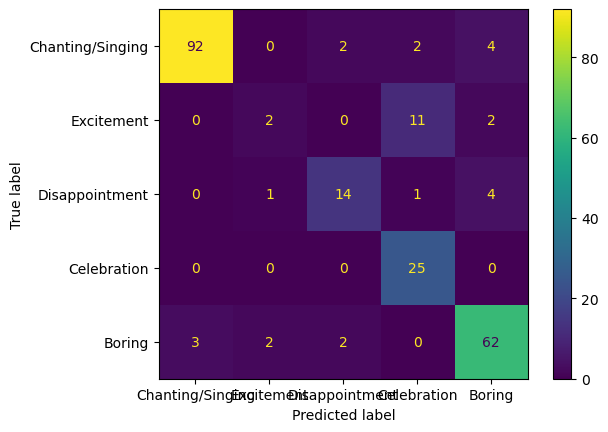

In [175]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta.get('labels').keys()
)
cmd.plot()

print(skm.classification_report(pred.label_ids, pred.predictions.argmax(1)))

In [176]:
id2label = {v:k for k,v in meta['labels'].items()}

In [177]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       100
           1       0.40      0.13      0.20        15
           2       0.78      0.70      0.74        20
           3       0.64      1.00      0.78        25
           4       0.86      0.90      0.88        69

    accuracy                           0.85       229
   macro avg       0.73      0.73      0.71       229
weighted avg       0.85      0.85      0.84       229



In [178]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

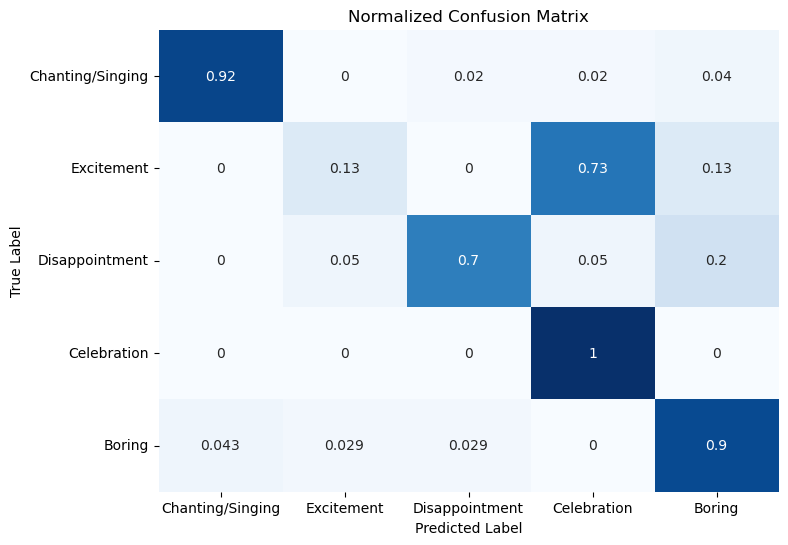

In [179]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

# Change Labels Celebration (3) to Excitement (1)

In [109]:
arrays['y']

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 2, 2, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 3, 3, 3, 3, 2, 2, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 4,
       4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [110]:
print(arrays['y'][arrays['y']==3])
print(len(arrays['y'][arrays['y']==3]))

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3]
85


In [111]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 3, nparray2)
nparray2

In [113]:
met_labels = {
     'Chanting/Singing': 0,
     'Excitement': 1,
     'Disappointment': 2,
     #'Celebration': 3,
     'Boring': 3 #former 4
}
met_labels

{'Chanting/Singing': 0, 'Excitement': 1, 'Disappointment': 2, 'Boring': 3}

In [114]:
# Model

In [115]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta_labels),
    label2id = meta_labels,
    id2label = {v:k for k,v in meta_labels.items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [116]:
preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": nparray2,
})

In [ ]:
hf_dataset

In [117]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [118]:
import transformers

batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [119]:
# select one train test split
(train_index, test_index) = next(gss.split(**arrays))

In [120]:
train_ds = hf_dataset.select(train_index)
train_ds

In [121]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [122]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.6122, 1.2514, 3.7750, 0.7678], device='cuda:0')


In [123]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=hf_dataset.select(train_index),
    eval_dataset=hf_dataset.select(test_index),
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

In [124]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,1.235700,1.045955,0.646288,0.445478,0.611513
20,0.754400,0.737971,0.781659,0.714663,0.794865
30,0.398400,0.579948,0.838428,0.722953,0.821365
40,0.307400,0.534325,0.847162,0.792501,0.855180
50,0.183300,0.537179,0.838428,0.751011,0.830993
60,0.143400,0.424430,0.886463,0.840524,0.884910
70,0.149600,0.441108,0.855895,0.812489,0.858287
80,0.079300,0.468167,0.851528,0.804536,0.851207
90,0.067900,0.437218,0.864629,0.824745,0.862464
100,0.051600,0.428928,0.882096,0.844082,0.882310


TrainOutput(global_step=105, training_loss=0.32321885923544563, metrics={'train_runtime': 451.7831, 'train_samples_per_second': 7.493, 'train_steps_per_second': 0.232, 'total_flos': 2.2043372873475686e+17, 'train_loss': 0.32321885923544563, 'epoch': 4.8})

In [125]:
pred = trainer.predict(hf_dataset.select(test_index))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       100
           1       0.87      0.85      0.86        40
           2       0.76      0.65      0.70        20
           3       0.78      0.91      0.84        69

    accuracy                           0.87       229
   macro avg       0.85      0.83      0.83       229
weighted avg       0.88      0.87      0.87       229



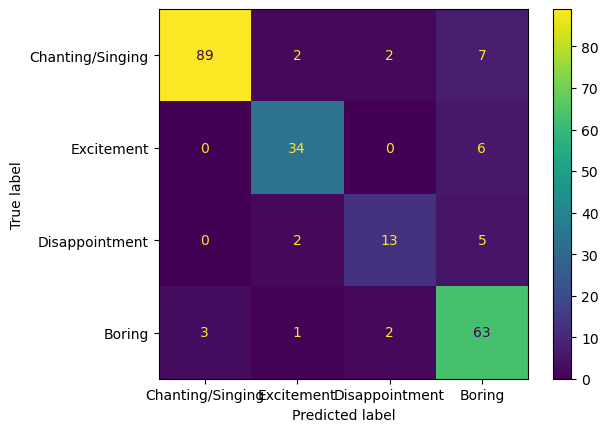

In [127]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta_labels.keys()
)
cmd.plot()

print(skm.classification_report(pred.label_ids, pred.predictions.argmax(1)))

In [133]:
id2label = {v:k for k,v in meta_labels.items()}

In [134]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       100
           1       0.87      0.85      0.86        40
           2       0.76      0.65      0.70        20
           3       0.78      0.91      0.84        69

    accuracy                           0.87       229
   macro avg       0.85      0.83      0.83       229
weighted avg       0.88      0.87      0.87       229



In [135]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

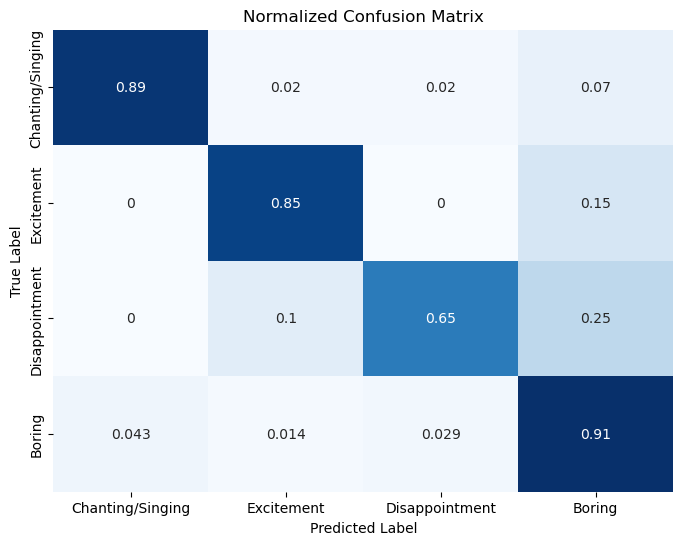

In [136]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()

# Change Labels Celebration (3) to Excitement (1) and Boring (4) to Dissappointment (2)

## Prepare Data

In [138]:
nparray2 = np.where(arrays['y']==3, 1, arrays['y'])
nparray2 = np.where(nparray2==4, 2, nparray2)
nparray2

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [139]:
meta_labels = {
     'Chanting/Singing': 0,
     'Excitement': 1,
     'Disappointment': 2,
     #'Celebration': 3,
     #'Boring': 4
}
meta_labels

{'Chanting/Singing': 0, 'Excitement': 1, 'Disappointment': 2}

##  Model and prepare Data for Training

In [140]:
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
device = 'cuda'

feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model2train = AutoModelForAudioClassification.from_pretrained(
    model_name,
    num_labels = len(meta_labels),
    label2id = meta_labels,
    id2label = {v:k for k,v in meta_labels.items()},
    ignore_mismatched_sizes = True
)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [141]:
preprocessed_audio = feature_extractor(
    arrays['X'],
    sampling_rate = meta['sample_rate'],
    return_tensors = "pt"
)

hf_dataset = Dataset.from_dict({
    "input_values": preprocessed_audio['input_values'],
    "label": nparray2,
})

In [142]:
hf_dataset

Dataset({
    features: ['input_values', 'label'],
    num_rows: 906
})

In [143]:
hf_dataset['label']

[2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [144]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, train_size=.8, random_state=42)
gss.get_n_splits()

for i, (train_index, test_index) in enumerate(gss.split(**arrays)):
    print(f"Fold {i}:")
    print(f"  Train: source={set(arrays['groups'][train_index])}")
    print(f"  Test:  source={set(arrays['groups'][test_index])}")

Fold 0:
  Train: source={np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(1), np.int64(5), np.int64(14)}
Fold 1:
  Train: source={np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(2), np.int64(13), np.int64(6)}
Fold 2:
  Train: source={np.int64(0), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(14), np.int64(15)}
  Test:  source={np.int64(8), np.int64(1), np.int64(13), np.int64(5)}
Fold 3:
  Train: source={np.int64(1), np.int64(3), np.int64(4), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(15)}
  Test:  source={np.int64(0), np.int64(2), np.

In [145]:
import transformers

batch_size = 8
args = transformers.TrainingArguments(
    f'{model_name.split("/")[-1]}-ft_stadium',

    learning_rate=1e-5,
    warmup_ratio=0.1,


    eval_strategy = "steps",
    eval_steps = 10,
    logging_steps=10,

    save_strategy = "epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    gradient_accumulation_steps=4,
    num_train_epochs=5,
    load_best_model_at_end=False,
    push_to_hub=False,
)

In [146]:
# select one train test split
(train_index, test_index) = next(gss.split(**arrays))

In [147]:
train_ds = hf_dataset.select(train_index)
train_ds

Dataset({
    features: ['input_values', 'label'],
    num_rows: 677
})

In [148]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels").to(torch.long)  # Labels in int64 konvertieren
        outputs = model(**inputs)
        logits = outputs.logits.to(torch.float32)  # Logits in float32 konvertieren

        # Loss-function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        
        metrics = {
            'accuracy': skm.accuracy_score(labels, preds),
            'macro_f1': skm.f1_score(labels, preds, average='macro'),
            'weighted_f1': skm.f1_score(labels, preds, average='weighted')
        }
        
        return metrics

In [149]:
class_weights = compute_class_weight(
    class_weight="balanced",  
    classes=np.unique( hf_dataset['label']),  
    y = hf_dataset['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.8162, 1.6685, 0.8507], device='cuda:0')


In [150]:
trainer = CustomTrainer(
    model=model2train,
    args=args,
    train_dataset=hf_dataset.select(train_index),
    eval_dataset=hf_dataset.select(test_index),
    processing_class = feature_extractor, #tokenizer=feature_extractor,
    class_weights=class_weights,
    compute_metrics=CustomTrainer.compute_metrics
)

In [151]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1
10,0.977300,0.720295,0.781659,0.759801,0.773878
20,0.513600,0.441514,0.847162,0.835867,0.851905
30,0.270000,0.351527,0.864629,0.855270,0.866870
40,0.224200,0.315905,0.886463,0.880588,0.887707
50,0.152400,0.284083,0.912664,0.910684,0.913434
60,0.110900,0.290458,0.899563,0.892177,0.901275
70,0.128900,0.267692,0.903930,0.898858,0.904982
80,0.071900,0.281176,0.903930,0.905126,0.904702
90,0.054700,0.270399,0.903930,0.900177,0.904681
100,0.051300,0.276745,0.912664,0.909253,0.913273


TrainOutput(global_step=105, training_loss=0.24478706490425836, metrics={'train_runtime': 452.2229, 'train_samples_per_second': 7.485, 'train_steps_per_second': 0.232, 'total_flos': 2.2043176203504845e+17, 'train_loss': 0.24478706490425836, 'epoch': 4.8})

In [152]:
pred = trainer.predict(hf_dataset.select(test_index))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       100
           1       0.84      0.95      0.89        40
           2       0.88      0.94      0.91        89

    accuracy                           0.91       229
   macro avg       0.90      0.92      0.91       229
weighted avg       0.92      0.91      0.91       229



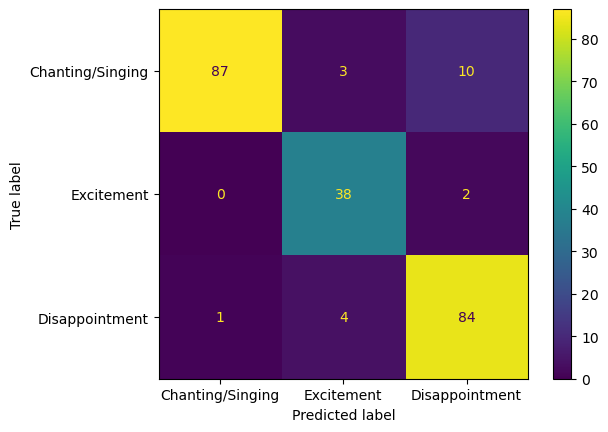

In [153]:
cmd = skm.ConfusionMatrixDisplay(
    skm.confusion_matrix(pred.label_ids, pred.predictions.argmax(1)),
    display_labels = meta_labels.keys()
)
cmd.plot()

print(skm.classification_report(pred.label_ids, pred.predictions.argmax(1)))

In [154]:
id2label = {v:k for k,v in meta_labels.items()}

In [155]:
print(classification_report(pred.label_ids, pred.predictions.argmax(1)))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       100
           1       0.84      0.95      0.89        40
           2       0.88      0.94      0.91        89

    accuracy                           0.91       229
   macro avg       0.90      0.92      0.91       229
weighted avg       0.92      0.91      0.91       229



In [156]:
cm = confusion_matrix(pred.label_ids, pred.predictions.argmax(1), normalize='true')

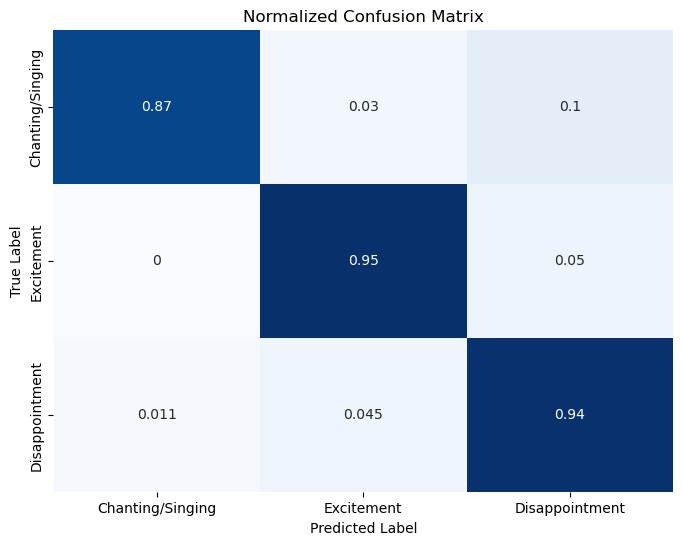

In [157]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=False, xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()